<a href="https://colab.research.google.com/github/VanniaMWD/vannia-hnatiuk-webDev-Portfolio/blob/main/ARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="light-bulb.png" alt="Flowers in Chania" style="float:left;width:100px;height:100px;">
<center><h1 style="color:#B40404;">Electric Power Generation prediction in Canada</h1></center>

<h5 style="color:#585858;">Author: Vannia Hnatiuk</h5>
<h5 style="color:#585858;">Date: April 4<sup>th</sup>, 2022</h5>

[1. Modeling](#one)<br>
    [1.1 ARIMA on seasonal difference](#three-one)<br>
    [1.2 ARIMA on original data](#three-two)<br>
    [1.3 ARIMA on logarithmic transformed data](#three-three)<br>
    [1.3 Facebook Prophet](#three-three)<br>
[2. Insights](#two)<br>
[3. References](#three)<br>

Importing the necessary library to perform the analysis

In [3]:
pip install pmdarima

In [4]:
import numpy as np
import pandas as pd

# plotting
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import seaborn as sns

# stats
from statsmodels.api import tsa # time series analysis
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import month_plot
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#sklearn
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error


#new pandas index
from pandas import Int64Index as NumericIndex

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
canada=pd.read_csv('/content/drive/MyDrive/can_50_08.csv',parse_dates=['REF_DATE'])
canada.head()


,REF_DATE,VALUE
0,1950-01-01,4081000.0
1,1950-02-01,3780000.0
2,1950-03-01,4186000.0
3,1950-04-01,4070000.0
4,1950-05-01,4425000.0


<p>A fundamental step for a Time Series Analysis is to assign the 'date' column as an index of the dataframe</p>

In [7]:
canada = canada.set_index('REF_DATE')
canada.head()

,VALUE
REF_DATE,
1950-01-01,4081000.0
1950-02-01,3780000.0
1950-03-01,4186000.0
1950-04-01,4070000.0
1950-05-01,4425000.0


In [9]:
canada.rename(columns = {'VALUE':'POWER'}, inplace = True)

<h2><a style="color:#B40404;" id='one-two'>Canada</a> </h2>

<h4 style="color:#B40404;">System Representation</h4>

In [11]:
# add lines for each column
fig = px.line(canada, x=canada.index, y=canada['POWER'], template='ggplot2')

# axis labels and title
fig.update_layout(
    yaxis_title="Megawatt-hour", 
    xaxis_title="Decades",
    legend_title="Power", 
    title="Power Generation over time",
)

# activate slider
fig.update_xaxes(rangeslider_visible=True)

fig.show()

<p>The Electricity generation is defined by an Upstream Trend, when year by year: more electricity is being generated. The seasonality exhibits peaks in winter months (from November to January). This is because in winther months: days are shorter and cooler. For this reason the production tries to fulfill this demand for ilumination and heating. 
Later, the generation starts to decline into warmer months when ilumination and heating is less required. Up to a slight peak in July and August when temperature rises and more electricity is required for cooling systems. Cooling systems appliances consume immense loads of power. Equally important,the distance between peaks and valleys fluctuates year by year showing an increasing variance.</p>

To know the time span its used the <span style="color:#B40404;">.min()</span> and <span style="color:#B40404;">.max()</span>

<h3><a style="color:#B40404;" id='two-four'><u>Trend Decomposition</a></u></h3>

In order to obtain a stationary curve, it is necessary to perform a trend-seasonal decomposition where we can obtain:
- a trend component $T_t$ calculated using a moving average,
- a seasonal component $S_t$ which is the monthly/daily average of the de-trended series, and
- the residual $R_t$ that remains after subtracting the trend and seasonal component from the original series.

Adding up these three components will give back the original series:

$$y_t = T_t + S_t + R_t$$

This can be performed through the function <span style="color:#B40404;" > seasonal_decompose</span> from <span style="color:#B40404;"> stats_model</span>. Where the decomposition is going to be in a <span style="color:#B40404;" >multiplicative form</span>. This is because the pattern of the system shows a minimal grade of additive and great multiplicative factor.

In [12]:
decomposition = tsa.seasonal_decompose(canada, model='multiplicative')

In [13]:
canada["Trend"] = decomposition.trend
canada["Seasonal"] = decomposition.seasonal
canada["Residual"] = decomposition.resid

canada.sample(10)

,POWER,Trend,Seasonal,Residual
REF_DATE,,,,
2005-12-01,57092582.0,4.973401e+07,1.112014,1.032324
1968-06-01,13302000.0,1.455396e+07,0.909138,1.005324
1964-01-01,11675000.0,1.065629e+07,1.150086,0.952621
1970-09-01,15744000.0,1.718696e+07,0.904956,1.012251
2001-04-01,45740007.0,4.770079e+07,0.975749,0.982726
2007-11-01,51217155.0,NaN,1.024510,NaN
1992-08-01,38018772.0,4.191886e+07,0.939373,0.965496
1997-04-01,45041842.0,4.616703e+07,0.975749,0.999875
1998-07-01,44305359.0,4.537075e+07,0.924625,1.056123


In [14]:
cols = ["Trend", "Seasonal", "Residual"]

fig = make_subplots(rows=3, cols=1, subplot_titles=cols)

for i, col in enumerate(cols):
    fig.add_trace(
        go.Scatter(x=canada.index, y=canada[col],line_color='#F8766D'),
        row=i+1,
        col=1,
    )

fig.update_layout(height=800, width=1200, showlegend=False)
fig.update_layout(plot_bgcolor='#F0ECEC')
fig.show()

Interpretation of the graph:
<ul>
<li>The trend shows an increase of power generation with some dips in the year 75', 82', 90', 98', 99', 2001, 2004 and 2006. </li>
<li>The seasonal plot it shows constant seasonality and same pattern.</li>
<li>The residuals display some seasonality and fluctuating variance <span style="color:#B40404;">"heteroscedascity"</span></li>
</ul>

<center><h2><a style="color:#B40404;" id='two'>Modeling </h2></center>

In [15]:
#Yearly seasonal difference
canada["seasonal_difference"] = canada["POWER"].diff(12)

<h3><a style="color:#B40404;" id='three-one'><u>ARIMA model on seasonal difference on a yearly basis</u></h3>

In [16]:
fig = px.line(canada, x=canada.index, y="seasonal_difference",template='ggplot2')

fig.update_layout(
    yaxis_title="Difference Megawattshour", 
    xaxis_title="Date",
    title="Seasonal Difference on yearly basis",
    plot_bgcolor='#F0ECEC'
)

fig.show()

The seasonal Difference showed an expanded variance: however, the mean lands at 0 at the seasonal difference

In [18]:
sm.tsa.stattools.kpss(canada['seasonal_difference'].dropna(), regression='ct', lags='auto', store=False)

(0.19714449609740187,
 0.017070813963474298,
 15,
 {'1%': 0.216, '10%': 0.119, '2.5%': 0.176, '5%': 0.146})

Because the <span style="color:#B40404;"> p-value </span> is  <span style="color:#B40404;">0.017</span>. Since this value is less than .05, we are able to reject the null hypothesis of the KPSS test. For this reason, the time series trend is <span style="color:#B40404;font-weight:bold">not stationary</span>.

In [58]:
canada['seasonal_difference']

REF_DATE
1950-01-01          NaN
1950-02-01          NaN
1950-03-01          NaN
1950-04-01          NaN
1950-05-01          NaN
                ...    
2007-08-01     408886.0
2007-09-01    1003422.0
2007-10-01    1159018.0
2007-11-01    3775622.0
2007-12-01    2763734.0
Name: seasonal_difference, Length: 696, dtype: float64

<h5 style="color:#B40404;">Splitting the dataset</h4>

The training dataset will be divided in years previous to 2005 whereas the test dataset will cover 3 years later.

In [19]:
train = canada.loc[canada.index <= "2005-12-01", "seasonal_difference"].dropna()
test = canada.loc[canada.index >= "2005-12-01", "seasonal_difference"]

In [21]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=train.index, y=train, mode='lines', line_color='#A6857A', name="Train"))
fig.add_trace(go.Scatter(x=test.index, y=test, mode='lines',line_color='#F8766D', name="Test"))
fig.update_layout(
    yaxis_title="Difference Megawatt hour", 
    xaxis_title="Date",
    title="Change in Megawatt hour over Prior Year"
)
fig.update_layout(plot_bgcolor='#F0ECEC')
fig.show()

Looking for autocorrelation for <span style="color:#B40404;font-size:110%;font-weight:bold"> 12</span> lags.

In [22]:
fig = px.scatter(
    x=canada["POWER"], 
    y=canada["POWER"].shift(12), # 12-month lagged observations, season
    template='ggplot2')
fig.update_layout(
    xaxis_title="Electricity generation on Current Year", 
    yaxis_title="Electricity Year Lagged"
)
fig.update_layout(plot_bgcolor='#F0ECEC')
fig.show()

<h5 style="color:#B40404;"> Autocorrelation Function</h5>

Autocorrelation Function and Partial Correlation Function are auxiliar to configure ARIMA models. The autocorrelation function helps to set parameter q (where a lag repeats seasonality).

<blockquote>Importantly, the order of differencing should not be too great. In general, the value of each parameter of an ARIMA(p, d, q) model should be kept as small as possible to avoid unwarranted complexity and overfitting to the sample data. As a not-at-all-universal rule of thumb, you should be quite skeptical of values of d over 2 and values of p and q over 5 or so. Also, you should expect either the p or q term to dominate and the other to be relatively small. These are practitioner notes gathered from analysts and not hard-and-fast mathematical truths.</blockquote>

Nielsen, Aileen.<i>Practical Time Series Analysis</i>, O'Reilly Media, Inc, October 2019

Autocorrelation in <span style="color:#B40404;font-size:100%;font-weight:bold">seasonal difference</span>.

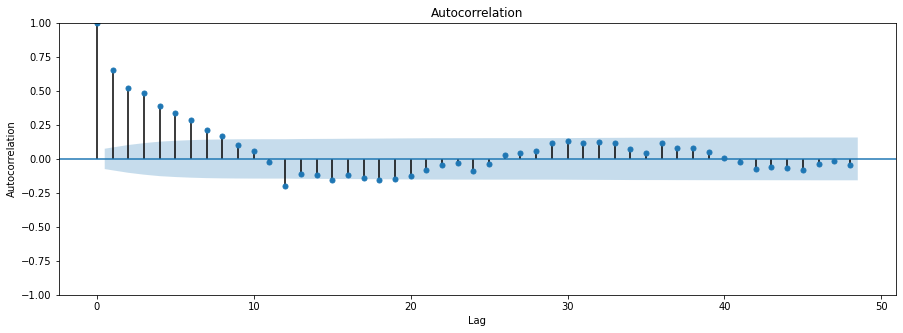

In [62]:
plt.figure(figsize=(15, 5))
plot_acf(canada["seasonal_difference"].dropna(), lags=48, ax=plt.gca())
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

The plot from the autocorrelation function shows <span style="color:#B40404;font-size:110%;font-weight:bold"> 8 </span> significant lags to set parameter <i style="color:#B40404;font-size:110%;font-weight:bold"> q </i> to the SARIMAX model.

<h5 style="color:#B40404;">Partial Autocorrelation</h5>

<p>In this case the partial correlation indicates which lags start fading and in this case we can determine parameter <b>p</b></p>

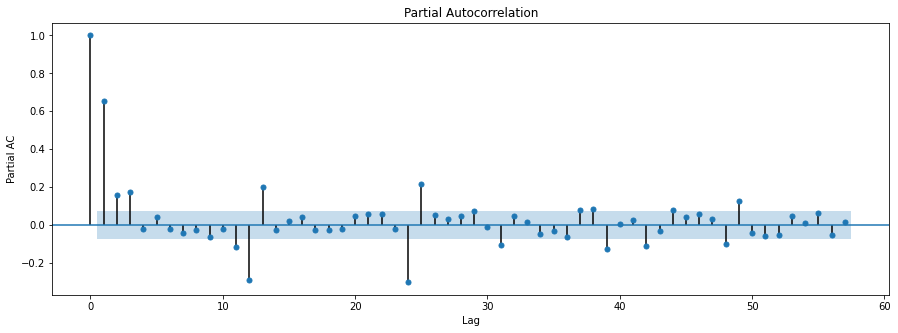

In [23]:
plt.figure(figsize=(15, 5))
plot_pacf(canada["seasonal_difference"].dropna(), lags=57, ax=plt.gca())
plt.xlabel('Lag')
plt.ylabel('Partial AC')
plt.show()

The plot from the partial autocorrelation function shows <span style="color:#B40404;font-size:110%;font-weight:bold">15</span> significant lags to set parameter <i style="color:#B40404;font-size:110%;font-weight:bold"> p </i> to the SARIMAX model.

<h4 style="color:#B40404;">SARIMAX model</h4>

<p>This model used the parameters given by the plots of the autocorrelation function and the partial correlation function. Parameter <b>d </b>was obtained through an automated function from the EDA notebook</p>.

In [24]:

model = SARIMAX(train, order=(15, 1, 8), trend="ct") #Random walk: (0,1,0)
model_fit = model.fit(disp=False)

model_fit.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



<class 'statsmodels.iolib.summary.Summary'>
"""
                            Statespace Model Results                           
===============================================================================
Dep. Variable:     seasonal_difference   No. Observations:                  660
Model:               SARIMAX(15, 1, 8)   Log Likelihood               -9933.089
Date:                 Wed, 30 Mar 2022   AIC                          19918.178
Time:                         03:31:18   BIC                          20034.936
Sample:                     01-01-1951   HQIC                         19963.437
                          - 12-01-2005                                         
Covariance Type:                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -2116.5756    2.2e+04     -0.096      0.923   -4.52e+04     4.1e+04
drift         30.0467     52.396      0.573      0.566     -72.647     132.741
ar.L1         -0.4224      0.182     -2.318      0.020      -0.780      -0.065
ar.L2         -0.2070      0.196     -1.058      0.290      -0.591       0.177
ar.L3          0.2394      0.177      1.355      0.176      -0.107       0.586
ar.L4         -0.2289      0.073     -3.137      0.002      -0.372      -0.086
ar.L5          0.3017      0.092      3.273      0.001       0.121       0.482
ar.L6          0.4480      0.052      8.551      0.000       0.345       0.551
ar.L7          0.5117      0.097      5.268      0.000       0.321       0.702
ar.L8         -0.1965      0.160     -1.228      0.219      -0.510       0.117
ar.L9         -0.0904      0.078     -1.154      0.248      -0.244       0.063
ar.L10        -0.0815      0.051     -1.611      0.107      -0.181       0.018
ar.L11         0.0402      0.049      0.824      0.410      -0.055       0.136
ar.L12        -0.2864      0.044     -6.555      0.000      -0.372      -0.201
ar.L13        -0.1404      0.066     -2.127      0.033      -0.270      -0.011
ar.L14        -0.1237      0.069     -1.789      0.074      -0.259       0.012
ar.L15        -0.0018      0.061     -0.030      0.976      -0.122       0.118
ma.L1          0.0151      0.177      0.085      0.932      -0.332       0.362
ma.L2         -0.1335      0.123     -1.085      0.278      -0.374       0.108
ma.L3         -0.3873      0.070     -5.538      0.000      -0.524      -0.250
ma.L4          0.3259      0.045      7.248      0.000       0.238       0.414
ma.L5         -0.4544      0.047     -9.726      0.000      -0.546      -0.363
ma.L6         -0.4779      0.061     -7.810      0.000      -0.598      -0.358
ma.L7         -0.3747      0.126     -2.977      0.003      -0.621      -0.128
ma.L8          0.6221      0.150      4.152      0.000       0.328       0.916
sigma2      7.988e+11   7.47e-07   1.07e+18      0.000    7.99e+11    7.99e+11
===================================================================================
Ljung-Box (Q):                       61.98   Jarque-Bera (JB):               240.36
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):              27.72   Skew:                            -0.16
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.11e+37. Standard errors may be unstable.
"""

<h5>1st prediction</h5>

In [25]:
predictions = model_fit.predict(start=0, end=len(train)+len(test)-1)

In [26]:
predictions

1951-01-01   -1.685452e+03
1951-02-01    4.817899e+05
1951-03-01    4.499229e+05
1951-04-01    6.549793e+05
1951-05-01    6.783620e+05
                  ...     
2007-09-01    1.608283e+06
2007-10-01    1.365602e+06
2007-11-01    1.467911e+06
2007-12-01    1.446367e+06
2008-01-01    1.764330e+06
Freq: MS, Length: 685, dtype: float64

In [27]:
predictions.index.min()

Timestamp('1951-01-01 00:00:00', freq='MS')

In [28]:
predictions.index.max()

Timestamp('2008-01-01 00:00:00', freq='MS')

In [29]:
predictions['2006':]

2006-01-01    9.522732e+05
2006-02-01    1.862618e+06
2006-03-01    8.210035e+05
2006-04-01    1.955857e+06
2006-05-01    6.470847e+05
2006-06-01   -5.682197e+05
2006-07-01    5.909943e+05
2006-08-01    4.376516e+05
2006-09-01    1.018067e+06
2006-10-01    1.165643e+06
2006-11-01    5.847775e+05
2006-12-01    1.487999e+05
2007-01-01    5.721660e+05
2007-02-01    1.073947e+06
2007-03-01    1.264522e+06
2007-04-01    1.168014e+06
2007-05-01    9.936352e+05
2007-06-01    1.042557e+06
2007-07-01    1.173231e+06
2007-08-01    1.788730e+06
2007-09-01    1.608283e+06
2007-10-01    1.365602e+06
2007-11-01    1.467911e+06
2007-12-01    1.446367e+06
2008-01-01    1.764330e+06
Freq: MS, dtype: float64

In [30]:
my_forecast=model_fit.forecast(steps=36)
my_forecast

2006-01-01    9.522732e+05
2006-02-01    1.862618e+06
2006-03-01    8.210035e+05
2006-04-01    1.955857e+06
2006-05-01    6.470847e+05
2006-06-01   -5.682197e+05
2006-07-01    5.909943e+05
2006-08-01    4.376516e+05
2006-09-01    1.018067e+06
2006-10-01    1.165643e+06
2006-11-01    5.847775e+05
2006-12-01    1.487999e+05
2007-01-01    5.721660e+05
2007-02-01    1.073947e+06
2007-03-01    1.264522e+06
2007-04-01    1.168014e+06
2007-05-01    9.936352e+05
2007-06-01    1.042557e+06
2007-07-01    1.173231e+06
2007-08-01    1.788730e+06
2007-09-01    1.608283e+06
2007-10-01    1.365602e+06
2007-11-01    1.467911e+06
2007-12-01    1.446367e+06
2008-01-01    1.764330e+06
2008-02-01    1.894624e+06
2008-03-01    1.728213e+06
2008-04-01    1.495235e+06
2008-05-01    1.530412e+06
2008-06-01    1.692470e+06
2008-07-01    1.807092e+06
2008-08-01    1.783532e+06
2008-09-01    1.611387e+06
2008-10-01    1.489158e+06
2008-11-01    1.528833e+06
2008-12-01    1.730622e+06
Freq: MS, dtype: float64

Joining the predictions with the forecast

In [31]:
whole_prediction=pd.concat([predictions,my_forecast['2008-02-01':]],ignore_index=False)

In [32]:
whole_prediction

1951-01-01   -1.685452e+03
1951-02-01    4.817899e+05
1951-03-01    4.499229e+05
1951-04-01    6.549793e+05
1951-05-01    6.783620e+05
                  ...     
2008-08-01    1.783532e+06
2008-09-01    1.611387e+06
2008-10-01    1.489158e+06
2008-11-01    1.528833e+06
2008-12-01    1.730622e+06
Freq: MS, Length: 696, dtype: float64

Training dataset using the <span style="color:#B40404;font-size:150%;font-weight:bold">seasonal difference</span>

In [37]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=train.index, y=train, mode='lines', line_color='#619CFF', name="Train"))
fig.add_trace(go.Scatter(x=test.index, y=test,line_color='#F8766D', mode='lines', name="Test"))
fig.add_trace(go.Scatter(x=whole_prediction.index, y=whole_prediction, mode='lines', line_color='#515A5A',
                         opacity=0.7, name="Predictions"))
fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(
    yaxis_title="Difference (MWH)", 
    xaxis_title="Date",
    title="Change in Electricity Generation over Prior Year"
)
fig.update_layout(plot_bgcolor='#F0ECEC')
fig.show()

Characterizing the SARIMAX model, the prediction attenuated the original difference line and starts to smooth towards the average of the system. For this reason, it needs more tunning for parameters q and p for better results.

<h5 style="color:#B40404;">Model Evaluation</h5>

In [38]:

train_mape = 100*mean_absolute_percentage_error(train, predictions[train.index])
test_mape = 100*mean_absolute_percentage_error(test, predictions[test.index])

print(f"Train MAPE on the difference: {round(train_mape, 2)}%")
print(f"Test MAPE on the difference: {round(test_mape, 2)}%")

Train MAPE on the difference: 173.01%
Test MAPE on the difference: 672.62%


In [39]:

train_MAE = mean_absolute_error(train, predictions[train.index])
test_MAE = mean_absolute_error(test, predictions[test.index])

print(f"Train MAE on the difference: {round(train_MAE, 2)}")
print(f"Test MAE on the difference: {round(test_MAE, 2)}")

Train MAE on the difference: 566156.91
Test MAE on the difference: 1520286.52


<p>Either the Mean Absolute Error and Mean Percentage Error shows a big margin between the forecast and the original data. This leads to look for other methods for a more precise prediction</p>

<h3><a style="color:#B40404;" id='three-two'><u>ARIMA model on original data</a></u></h3>

The training dataset will be divided in years previous to 2004 whereas the test dataset will cover 3 years later without seasonal difference and no transformation eiter. 

In [43]:
train2=canada.loc[:'2004','POWER']

In [44]:
test2=canada.loc['2004':,'POWER']
test2

REF_DATE
2004-01-01    58071726.0
2004-02-01    50420533.0
2004-03-01    49311591.0
2004-04-01    44234650.0
2004-05-01    42544138.0
2004-06-01    41747347.0
2004-07-01    46045442.0
2004-08-01    46070464.0
2004-09-01    42391075.0
2004-10-01    45654017.0
2004-11-01    48754118.0
2004-12-01    56046804.0
2005-01-01    58660124.0
2005-02-01    51031876.0
2005-03-01    53844989.0
2005-04-01    46504821.0
2005-05-01    45145394.0
2005-06-01    45769222.0
2005-07-01    48658569.0
2005-08-01    49206500.0
2005-09-01    44555418.0
2005-10-01    46967428.0
2005-11-01    50373952.0
2005-12-01    57092582.0
2006-01-01    56441389.0
2006-02-01    52672322.0
2006-03-01    54100224.0
2006-04-01    46323273.0
2006-05-01    45276180.0
2006-06-01    44511429.0
2006-07-01    48858918.0
2006-08-01    47752969.0
2006-09-01    41727894.0
2006-10-01    45416966.0
2006-11-01    47441533.0
2006-12-01    54574434.0
2007-01-01    57934815.0
2007-02-01    55195228.0
2007-03-01    54109989.0
2007-04-01    49

<h5 style="color:#B40404;"> Autocorrelation Function</h5>

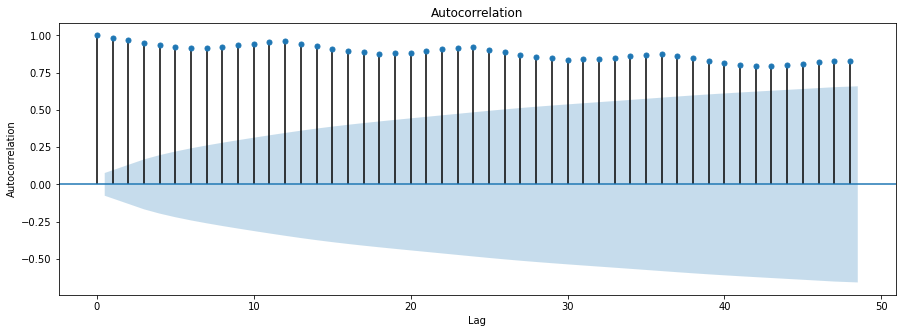

In [45]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(15, 5))

# put the acf plot on the current axis
plot_acf(train2, lags=48, ax=plt.gca()) #lags=58
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

The autocorrelation function points ideally to <span style="color:#B40404;font-size:110%;font-weight:bold">51-52 </span> significant lags  to set parameter <i style="color:#B40404;font-size:110%;font-weight:bold"> q </i> to the SARIMAX model. However, execution time will take long time and there is not a good trade off for forecast. For a first run on original data, 10 lags will be applied as a starter point.

<h5 style="color:#B40404;">Partial Autocorrelation</h5>

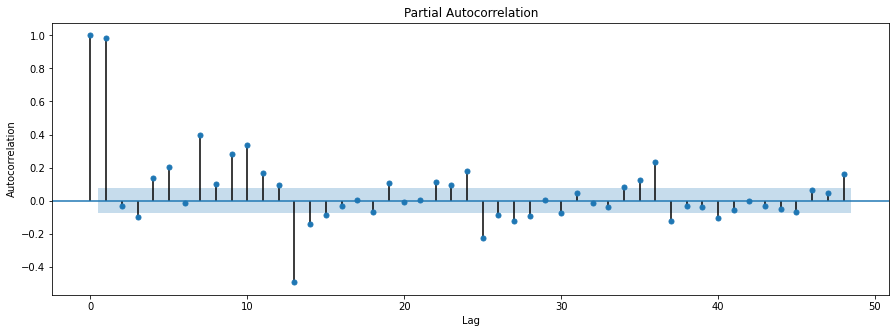

In [46]:

plt.figure(figsize=(15, 5))

# put the acf plot on the current axis
plot_pacf(train2, lags=48, ax=plt.gca()) #lags 58
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

The partial autocorrelation function indicates <span style="color:#B40404;font-size:110%;font-weight:bold">28</span> significant lags  to set parameter <i style="color:#B40404;font-size:110%;font-weight:bold"> p </i> to the SARIMAX model.

In [47]:
import pmdarima as pm

# Create auto_arima model
model1 = pm.auto_arima(train2, #time series
                    seasonal=True, # is the time series seasonal
                    m=12, # the seasonal period - one year
                    d=1, # non-seasonal difference order
                    D=1, # seasonal difference order
                    max_p=6, # max value of p to test 
                    max_q=6, # max value of p to test
                    max_P=6, # max value of P to test 
                    max_Q=6, # max value of Q to test 
                    information_criterion='aic', # used to select best mode
                    trace=True, # prints the information_criterion for each model it fits
                    error_action='ignore', # ignore orders that don't work
                    stepwise=True, # apply an intelligent order search
                    suppress_warnings=True) 

# Print model summary
print(model1.summary())


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=19530.287, Time=15.62 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=19788.316, Time=0.07 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=19640.292, Time=0.87 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=19551.427, Time=1.07 sec
 ARIMA(2,1,2)(0,1,1)[12]             : AIC=19528.752, Time=7.84 sec
 ARIMA(2,1,2)(0,1,0)[12]             : AIC=19669.742, Time=1.86 sec
 ARIMA(2,1,2)(0,1,2)[12]             : AIC=19530.108, Time=16.92 sec
 ARIMA(2,1,2)(1,1,0)[12]             : AIC=19594.750, Time=2.48 sec
 ARIMA(2,1,2)(1,1,2)[12]             : AIC=19526.442, Time=25.26 sec
 ARIMA(2,1,2)(2,1,2)[12]             : AIC=19526.084, Time=27.18 sec
 ARIMA(2,1,2)(2,1,1)[12]             : AIC=19527.994, Time=28.62 sec
 ARIMA(2,1,2)(3,1,2)[12]             : AIC=19527.792, Time=70.52 sec
 ARIMA(2,1,2)(2,1,3)[12]             : AIC=19526.846, Time=69.66 sec
 ARIMA(2,1,2)(1,1,3)[12]             : AIC=19526.304, Time=58.32 s

<h4 style="color:#B40404;font-weight:bold">1 <sup>st</sup> model run 

In [48]:
p_param = 3 #21 #12    #all possible significant lags from the partial autocorrelation function plot
d_param = 1   #0
q_param = 1

P_param= 2
D_param= 1
Q_param= 2
S_param= 12

model_raw = SARIMAX(train2, order=(p_param, d_param, q_param), seasonal_order=(P_param, D_param, Q_param, S_param), trend="ct")
model_fit_raw = model_raw.fit(disp=False)

model_fit_raw.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              POWER   No. Observations:                  660
Model:             SARIMAX(3, 1, 1)x(2, 1, 2, 12)   Log Likelihood               -9755.839
Date:                            Wed, 30 Mar 2022   AIC                          19533.677
Time:                                    04:05:43   BIC                          19582.873
Sample:                                01-01-1950   HQIC                         19552.763
                                     - 12-01-2004                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -1.282e+04   2.02e+04     -0.633      0.526   -5.25e+04    2.68e+04
drift         28.4373     42.126      0.675      0.500     -54.129     111.003
ar.L1          0.5525      0.080      6.937      0.000       0.396       0.709
ar.L2         -0.0117      0.051     -0.229      0.819      -0.112       0.088
ar.L3          0.0496      0.054      0.911      0.362      -0.057       0.156
ma.L1         -0.8556      0.072    -11.892      0.000      -0.997      -0.715
ar.S.L12      -0.6332      0.186     -3.406      0.001      -0.997      -0.269
ar.S.L24      -0.1386      0.071     -1.957      0.050      -0.277       0.000
ma.S.L12       0.0482      0.184      0.261      0.794      -0.313       0.409
ma.S.L24      -0.3438      0.151     -2.279      0.023      -0.639      -0.048
sigma2      9.581e+11      0.000   2.85e+15      0.000    9.58e+11    9.58e+11
===================================================================================
Ljung-Box (Q):                       71.14   Jarque-Bera (JB):               282.00
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              18.44   Skew:                            -0.22
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.59e+32. Standard errors may be unstable.
"""

In [49]:
predictions_raw = model_fit_raw.predict(start=0, end=len(train2)+len(test2)-1)

In [50]:
predictions_raw['2006':]

2006-01-01    5.981588e+07
2006-02-01    5.375848e+07
2006-03-01    5.367053e+07
2006-04-01    4.799727e+07
2006-05-01    4.599588e+07
2006-06-01    4.486382e+07
2006-07-01    4.860592e+07
2006-08-01    4.879621e+07
2006-09-01    4.454069e+07
2006-10-01    4.754949e+07
2006-11-01    5.046480e+07
2006-12-01    5.647803e+07
2007-01-01    6.063929e+07
2007-02-01    5.429130e+07
2007-03-01    5.417340e+07
2007-04-01    4.871150e+07
2007-05-01    4.684763e+07
2007-06-01    4.585642e+07
2007-07-01    4.979474e+07
2007-08-01    4.991319e+07
2007-09-01    4.588706e+07
2007-10-01    4.893581e+07
2007-11-01    5.182167e+07
2007-12-01    5.809362e+07
2008-01-01    6.192051e+07
2008-02-01    5.569924e+07
2008-03-01    5.562661e+07
2008-04-01    5.006598e+07
2008-05-01    4.814434e+07
2008-06-01    4.709695e+07
2008-07-01    5.095319e+07
2008-08-01    5.111359e+07
2008-09-01    4.699524e+07
2008-10-01    5.003179e+07
2008-11-01    5.293306e+07
2008-12-01    5.907651e+07
Freq: MS, dtype: float64

In [51]:
two_thousand_raw=model_fit_raw.forecast(steps=48)
two_thousand_raw

2005-01-01    5.940271e+07
2005-02-01    5.280416e+07
2005-03-01    5.277974e+07
2005-04-01    4.723400e+07
2005-05-01    4.531861e+07
2005-06-01    4.429924e+07
2005-07-01    4.822000e+07
2005-08-01    4.825882e+07
2005-09-01    4.425965e+07
2005-10-01    4.723620e+07
2005-11-01    5.000103e+07
2005-12-01    5.614147e+07
2006-01-01    5.981588e+07
2006-02-01    5.375848e+07
2006-03-01    5.367053e+07
2006-04-01    4.799727e+07
2006-05-01    4.599588e+07
2006-06-01    4.486382e+07
2006-07-01    4.860592e+07
2006-08-01    4.879621e+07
2006-09-01    4.454069e+07
2006-10-01    4.754949e+07
2006-11-01    5.046480e+07
2006-12-01    5.647803e+07
2007-01-01    6.063929e+07
2007-02-01    5.429130e+07
2007-03-01    5.417340e+07
2007-04-01    4.871150e+07
2007-05-01    4.684763e+07
2007-06-01    4.585642e+07
2007-07-01    4.979474e+07
2007-08-01    4.991319e+07
2007-09-01    4.588706e+07
2007-10-01    4.893581e+07
2007-11-01    5.182167e+07
2007-12-01    5.809362e+07
2008-01-01    6.192051e+07
2

In [55]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=train2.index, y=train2, mode='lines', name="Train"))
fig.add_trace(go.Scatter(x=test2.index, y=test2, mode='lines',line_color='#F8766D', name="Test"))
fig.add_trace(go.Scatter(x=predictions_raw.index, y=predictions_raw, mode='lines',
                         opacity=0.75, line_color='#A6857A', name="Predictions"))
fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(
    yaxis_title="Millions of Megawatts of Power Generated ", 
    xaxis_title="Date",
    title="Change in Electricity Generation over Prior Year"
)
fig.show()

Beautiful, the forecast basically overlaps the original time series.

<h5 style="color:#B40404;">Model Evaluation</h5>

In [56]:
predictions_raw = model_fit_raw.predict(start=0, end=len(train2)+len(test2)-1)

train_mape = 100*mean_absolute_percentage_error(train2, predictions_raw[train2.index])
test_mape = 100*mean_absolute_percentage_error(test2, predictions_raw[test2.index])

print(f"Train MAPE on the difference: {round(train_mape, 2)}%")
print(f"Test MAPE on the difference: {round(test_mape, 2)}%")

Train MAPE on the difference: 2.62%
Test MAPE on the difference: 2.37%


In [57]:
train_raw_MAE = mean_absolute_error(train2, predictions_raw[train2.index])
test_raw_MAE = mean_absolute_error(test2, predictions_raw[test2.index])

print(f"Train MAE on the difference: {round(train_raw_MAE, 2)}")
print(f"Test MAE on the difference: {round(test_raw_MAE, 2)}")

Train MAE on the difference: 574952.48
Test MAE on the difference: 1170516.39


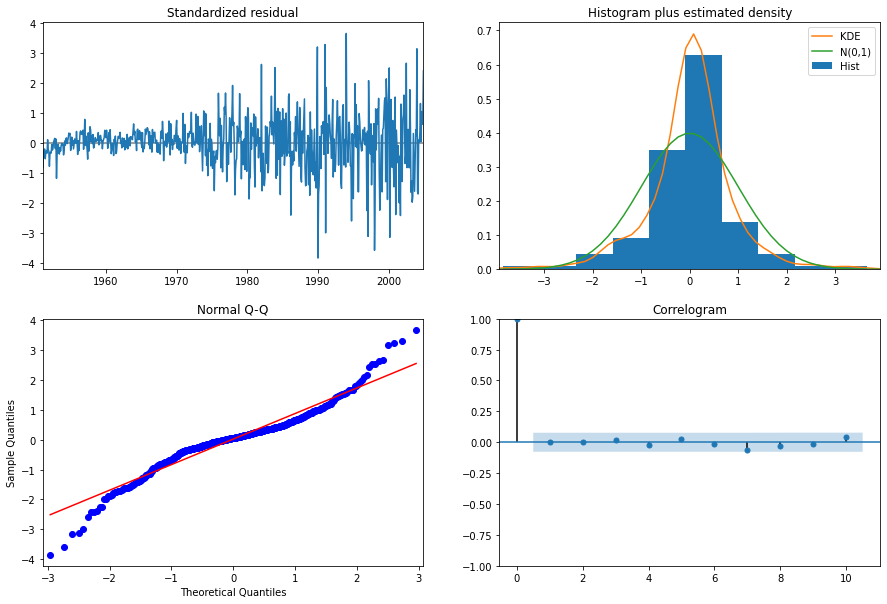

In [58]:

model_fit_raw.plot_diagnostics(figsize=(15,10))
plt.show()

<h4 style="color:#B40404;font-weight:bold">2<sup>nd</sup> model run with seasonal order </h4>

This model utilized a seasonal order with maximum p=5, d=1, q=2 and s=12. S was determined because it covers the regular patttern of the series happens every 12 months. The rest of the parameters were considered based on the reviewed literature :

<h3><a style="color:#B40404;" id='three-three'><u>ARIMA on Log Transformed Data</a></u></h3>

Applying Logarithmic transformation to train and test data

In [76]:
train_log=np.log(canada.loc[:'2003','POWER'])
test_log=np.log(canada.loc['2003':,'POWER'])

<h5 style="color:#B40404;"> Autocorrelation Function</h5>

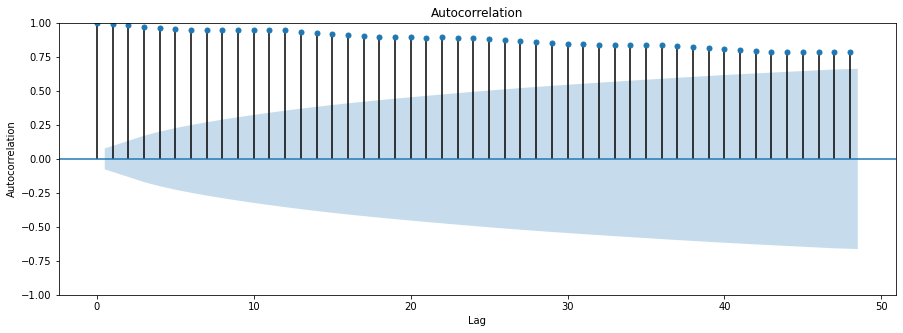

In [77]:
plt.figure(figsize=(15, 5))

# put the acf plot on the current axis
plot_acf(train_log, lags=48, ax=plt.gca()) #lags=58
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

<h5 style="color:#B40404;">Partial Autocorrelation</h5>

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



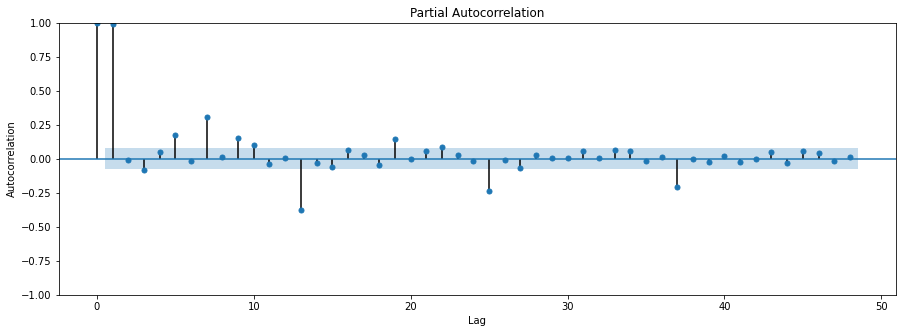

In [78]:
plt.figure(figsize=(15, 5))

# put the acf plot on the current axis
plot_pacf(train_log, lags=48, ax=plt.gca()) #lags 58
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

<h5>ARIMA on Log transformed Data</h5>

In [79]:
p_param = 1 #21 #12    #all possible significant lags from the partial autocorrelation function plot
d_param = 1   #0
q_param = 0 #15 #15       ##half lags from autocorrelation function plot

model_log = SARIMAX(train_log, order=(p_param, d_param, q_param), trend="ct")
model_log = model_log.fit(disp=False)

model_log.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  VALUE   No. Observations:                  648
Model:               SARIMAX(1, 1, 0)   Log Likelihood                 823.156
Date:                Tue, 29 Mar 2022   AIC                          -1638.312
Time:                        14:25:25   BIC                          -1620.423
Sample:                    01-01-1950   HQIC                         -1631.372
                         - 12-01-2003                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0076      0.006      1.217      0.224      -0.005       0.020
drift      -1.087e-05   1.52e-05     -0.713      0.476   -4.07e-05     1.9e-05
ar.L1         -0.0095      0.046     -0.205      0.837      -0.100       0.081
sigma2         0.0046      0.000     14.637      0.000       0.004       0.005
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                15.99
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               2.00   Skew:                            -0.24
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [80]:
predictions_log = model_log.predict(start=0, end=len(train2)+len(test2)-1)

In [81]:
forecast_log=model_log.forecast(steps=12)
forecast_log

2004-01-01    17.770490
2004-02-01    17.771058
2004-03-01    17.771605
2004-04-01    17.772141
2004-05-01    17.772666
2004-06-01    17.773181
2004-07-01    17.773684
2004-08-01    17.774177
2004-09-01    17.774659
2004-10-01    17.775131
2004-11-01    17.775591
2004-12-01    17.776041
Freq: MS, Name: predicted_mean, dtype: float64

In [82]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=train_log.index, y=train_log, mode='lines', name="Train"))
fig.add_trace(go.Scatter(x=test_log.index, y=test_log, mode='lines', name="Test"))
fig.add_trace(go.Scatter(x=predictions_log.index, y=predictions_log, mode='lines', name="Predictions"))
fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(
    yaxis_title="Total Electricity Generation in Megawatt-Hours", 
    xaxis_title="Date",
    title="Change in Electricity Generation over Prior Year"
)
fig.show()

In [83]:
train_log_mape = 100*mean_absolute_percentage_error(train_log, predictions_log[train_log.index])
test_log_mape = 100*mean_absolute_percentage_error(test_log, predictions_log[test_log.index])

print(f"Train MAPE on the difference: {round(train_log_mape, 2)}%")
print(f"Test MAPE on the difference: {round(test_log_mape, 2)}%")

Train MAPE on the difference: 0.48%
Test MAPE on the difference: 0.56%


In [84]:
train_log_MAE = mean_absolute_error(train_log, predictions_log[train_log.index])
test_log_MAE = mean_absolute_error(test_log, predictions_log[test_log.index])

print(f"Train MAE on the difference: {round(train_log_MAE, 2)}")
print(f"Test MAE on the difference: {round(test_log_MAE, 2)}")

Train MAE on the difference: 0.08
Test MAE on the difference: 0.1


<h2 style="color:#A802CA;font-weight:bold" >Reconstruction of Original signal</H2>

In [85]:
first_date = train_log.index.min()

# create an empty restored column
canada["restored"] = np.nan

# fill in the first 12 original values from VALUE
canada.loc[first_date: first_date + pd.DateOffset(months=11), "restored"] = \
    canada.loc[first_date: first_date + pd.DateOffset(months=11), "POWER"]

# use the current difference and 12-month lagged restored value to get the next restored
#restored = seasonal difference + restored
for date, val in canada.loc[first_date + pd.DateOffset(months=12):, "seasonal_difference"].items():
    canada.loc[date, "restored"] = canada.loc[date - pd.DateOffset(months=12), "restored"] + val

# check agreement everywhere (rounding errors can come up so check closeness rather than strict equality)
np.allclose(canada["POWER"], canada["restored"])

True

In [86]:
# use the original train diff values and predicted test values
canada.loc[train.index, "difference"] = canada.loc[train.index, "seasonal_difference"]
canada.loc[test.index, "difference"] = predictions[test.index]

# empty restored column
canada["signal_restored"] = np.nan

# fill in the first 12 original values
canada.loc[first_date: first_date + pd.DateOffset(months=11), "signal_restored"] = \
    canada.loc[first_date: first_date + pd.DateOffset(months=11), "POWER"]

# use the current difference and 12-month lagged restored value to get the next restored
for date, val in canada.loc[first_date + pd.DateOffset(months=12):, "difference"].items():
    canada.loc[date, "signal_restored"] = \
        canada.loc[date - pd.DateOffset(months=12), "signal_restored"] + val

In [87]:
canada.head(14)

,VALUE,Trend,Seasonal,Residual,seasonal_difference,restored,difference,signal_restored
REF_DATE,,,,,,,,
1950-01-01,4081000.0,NaN,1.150086,NaN,NaN,4081000.0,NaN,4081000.0
1950-02-01,3780000.0,NaN,1.040517,NaN,NaN,3780000.0,NaN,3780000.0
1950-03-01,4186000.0,NaN,1.079401,NaN,NaN,4186000.0,NaN,4186000.0
1950-04-01,4070000.0,NaN,0.975749,NaN,NaN,4070000.0,NaN,4070000.0
1950-05-01,4425000.0,NaN,0.956170,NaN,NaN,4425000.0,NaN,4425000.0
1950-06-01,4313000.0,NaN,0.909138,NaN,NaN,4313000.0,NaN,4313000.0
1950-07-01,4201000.0,4.271292e+06,0.924625,1.063721,NaN,4201000.0,NaN,4201000.0
1950-08-01,4199000.0,4.325583e+06,0.939373,1.033387,NaN,4199000.0,NaN,4199000.0
1950-09-01,4121000.0,4.380750e+06,0.904956,1.039505,NaN,4121000.0,NaN,4121000.0


In [88]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=train.index, y=canada.loc[train.index, "POWER"], mode='lines', name="Train"))
fig.add_trace(go.Scatter(x=test.index, y=canada.loc[test.index, "POWER"], mode='lines', name="Test"))
fig.add_trace(go.Scatter(x=test.index, y=canada.loc[test.index, "signal_restored"], mode='lines', name="prediction"))

fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(
    yaxis_title="Electicity generated in Millions of Megawatts", 
    xaxis_title="Date",
    title="Electricity Comparisson Real vs Reconstruction"
)
fig.show()

<h5> Residuals Diagnostics</h5>

In [89]:
fig = px.line(x=model_log.resid.index, y=model_log.resid)
fig.update_layout(
    yaxis_title="Residuals", 
    xaxis_title="Date",
    title="ARIMA model residuals"
)
fig
fig.show()

There is no clear pattern in the residuals and their mean is 0. Also we can appreciate it at the distribution in the histogram attached.

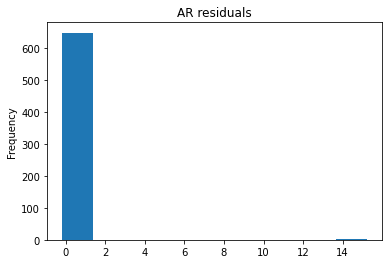

In [90]:
model_log.resid.plot(kind="hist")
plt.title("AR residuals")
plt.show()

In [91]:
model_log.resid.describe()

count    648.000000
mean       0.023360
std        0.601513
min       -0.170622
25%       -0.050159
50%        0.005248
75%        0.050594
max       15.214319
dtype: float64

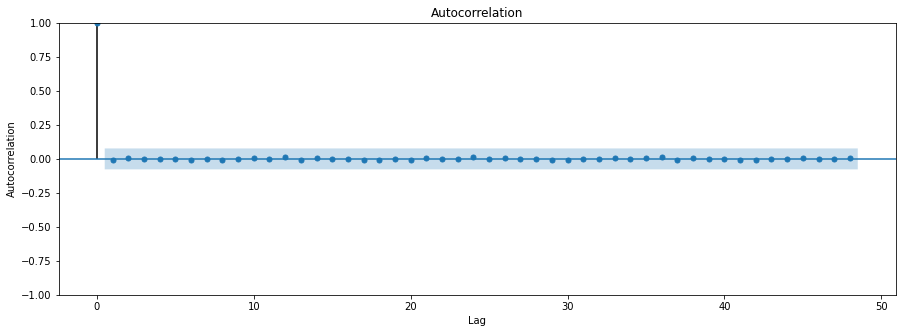

In [92]:
plt.figure(figsize=(15, 5))
plot_acf(model_log.resid, lags=48, ax=plt.gca())
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

No significant lags

<h3><a style="color:#4267B2;font-weight:bold" id='three-four'>Facebook Prophet</a></h3>

In [93]:

prophet_train = canada.loc[canada.index<= "2003-12-01", "POWER"].reset_index()
prophet_train.rename(columns={"REF_DATE": "ds", "POWER": "y"}, inplace=True)
prophet_train.head()

,ds,y
0,1950-01-01,4081000.0
1,1950-02-01,3780000.0
2,1950-03-01,4186000.0
3,1950-04-01,4070000.0
4,1950-05-01,4425000.0


In [94]:
model_prophet = Prophet(yearly_seasonality=1, seasonality_mode='multiplicative') #mcmc_samples=100
model_prophet.fit(prophet_train)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [95]:
future = model_prophet.make_future_dataframe(periods=len(test)+48, freq="MS", include_history=False)
future

,ds
0,2004-01-01
1,2004-02-01
2,2004-03-01
3,2004-04-01
4,2004-05-01
...,...
68,2009-09-01
69,2009-10-01
70,2009-11-01
71,2009-12-01


In [96]:
future

,ds
0,2004-01-01
1,2004-02-01
2,2004-03-01
3,2004-04-01
4,2004-05-01
...,...
68,2009-09-01
69,2009-10-01
70,2009-11-01
71,2009-12-01


In [97]:
# Notice we need to provide a dataframe for the predict method, it must also contain a `ds` column
forecast = model_prophet.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
68,2009-09-01,4.878918e+07,4.645716e+07,5.099205e+07
69,2009-10-01,5.197788e+07,4.983348e+07,5.406167e+07
70,2009-11-01,5.532436e+07,5.331653e+07,5.775140e+07
71,2009-12-01,5.775735e+07,5.548368e+07,5.998041e+07
72,2010-01-01,5.877019e+07,5.659568e+07,6.096901e+07


In [110]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2004-01-01,5.498567e+07,5.286297e+07,5.711559e+07
1,2004-02-01,5.428814e+07,5.221157e+07,5.647717e+07
2,2004-03-01,5.229380e+07,5.012721e+07,5.439402e+07
3,2004-04-01,4.929874e+07,4.720451e+07,5.127049e+07
4,2004-05-01,4.633138e+07,4.422367e+07,4.844911e+07
...,...,...,...,...
68,2009-09-01,4.878918e+07,4.645716e+07,5.099205e+07
69,2009-10-01,5.197788e+07,4.983348e+07,5.406167e+07
70,2009-11-01,5.532436e+07,5.331653e+07,5.775140e+07
71,2009-12-01,5.775735e+07,5.548368e+07,5.998041e+07


In [111]:
forecast.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yearly', 'yearly_lower', 'yearly_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'yhat'],
      dtype='object')

In [98]:
from fbprophet.plot import plot_plotly

fig = plot_plotly(model_prophet, forecast) # returns a plotly Figure object
fig.show()

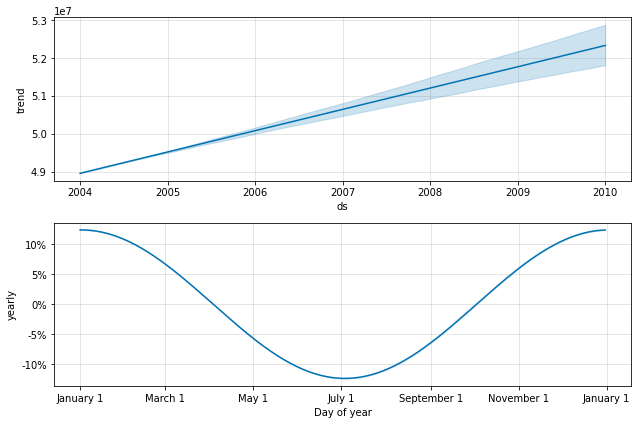

In [99]:
fig = model_prophet.plot_components(forecast)

In [100]:
prophet_train.shape

(648, 2)

In [101]:
forecast.shape

(73, 16)

In [102]:
prophet_train.tail()

,ds,y
643,2003-08-01,45425311.0
644,2003-09-01,40298546.0
645,2003-10-01,42966467.0
646,2003-11-01,46468433.0
647,2003-12-01,52222674.0


In [103]:
forecast[['ds','yhat_lower','yhat_upper','yhat']]

,ds,yhat_lower,yhat_upper,yhat
0,2004-01-01,5.286297e+07,5.711559e+07,5.498567e+07
1,2004-02-01,5.221157e+07,5.647717e+07,5.428814e+07
2,2004-03-01,5.012721e+07,5.439402e+07,5.229380e+07
3,2004-04-01,4.720451e+07,5.127049e+07,4.929874e+07
4,2004-05-01,4.422367e+07,4.844911e+07,4.633138e+07
...,...,...,...,...
68,2009-09-01,4.645716e+07,5.099205e+07,4.878918e+07
69,2009-10-01,4.983348e+07,5.406167e+07,5.197788e+07
70,2009-11-01,5.331653e+07,5.775140e+07,5.532436e+07
71,2009-12-01,5.548368e+07,5.998041e+07,5.775735e+07


In [107]:
df_merge = pd.merge(prophet_train, forecast[['ds','yhat_lower','yhat_upper','yhat']],on='ds')
df_merge

,ds,y,yhat_lower,yhat_upper,yhat


In [109]:
y_true = prophet_train['y'].values
y_pred = forecast['yhat'].values
mae_01 = mean_absolute_error(y_true, y_pred)
mape_01 = mean_absolute_percentage_error(y_true, y_pred)

ValueError: ignored

<a href='https://facebook.github.io/prophet/docs/diagnostics.html#hyperparameter-tuning'> Documentation</a>

Electricity 
Gorse, Christopher Johnston, David Pritchard, Martin. (2012). Dictionary of Construction, Surveying and Civil Engineering - electric power. (pp. 132). Oxford University Press. Retrieved from
https://app.knovel.com/hotlink/pdf/id:kt00C1GZJ1/dictionary-construction/electric-power

<a href='https://energi.media/news/how-the-2021-summer-heat-dome-affected-electricity-demand-in-western-canada/'>How the 2021 summer heat dome affected electricity demand in western Canada</a>